# Complete Simulation Chain for Visibility Calculation

## Read in Config

In [1]:
import pyvisgen.simulation.utils as ut
import pyvisgen.layouts.layouts as layouts
import astropy.constants as const
from astropy import units as un
import time as t
import numpy as np
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
# rc = ut.read_config('/net/nfshome/home/sfroese/pyvisgen/config/default.toml')
rc = ut.read_config("../config/default.toml")
array_layout = layouts.get_array_layout('eht')
src_crd = rc['src_coord']

wave1 = const.c/((float(rc['channel'].split(':')[0])-float(rc['channel'].split(':')[1])/2)*10**6/un.second)/un.meter
wave2 = const.c/((float(rc['channel'].split(':')[0])+float(rc['channel'].split(':')[1])/2)*10**6/un.second)/un.meter

## Generate (l,m)-plane / FOV

In [3]:
import pyvisgen.simulation.scan as scan
import matplotlib.pyplot as plt

8.911845086155491e-10
4.318124919498908e-10


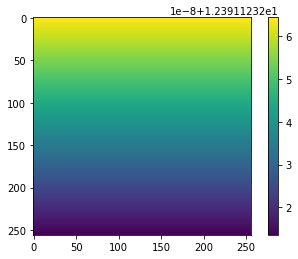

In [4]:
rd = scan.rd_grid(rc['fov_size']*np.pi/(3600*180),256, src_crd)
lm = scan.lm_grid(rd, src_crd)
plt.imshow(np.rad2deg(rd[:,:,1]))
plt.colorbar()
print(rc['fov_size']*np.pi/(3600*180))
print(np.max(lm[:,:,0]))

## Calculate Start and Stop times for every measurement

In [5]:
time = ut.calc_time_steps(rc)

## Calculate Baselines for one measurement

In [6]:
baselines = scan.get_baselines(src_crd, time[:31], array_layout)

## Calculate Visibilities

In [7]:
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt

In [8]:
hdul = fits.open('celestial-03-05.fits')
img = hdul[0].data.astype(np.float32)
img = torch.tensor(img)

I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img

In [9]:
%%time
start = t.time()
torch.set_num_threads(8)
X1 = scan.corrupted(lm, baselines, wave1, time[0:31], src_crd, array_layout, I, rd)
X2 = scan.corrupted(lm, baselines, wave2, time[0:31], src_crd, array_layout, I, rd)

CPU times: user 28.5 s, sys: 15.7 s, total: 44.2 s
Wall time: 5.55 s


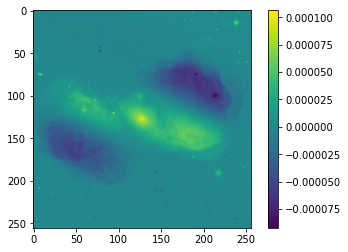

In [10]:
plt.imshow(X1[:,:,5,0,0].real)
plt.colorbar()
plt.show()

1.0


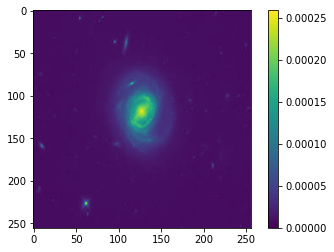

In [11]:
from PIL import Image
img = np.asarray(Image.open('150.jpg'))
img = img/np.sum(img)
print(np.sum(img))
plt.imshow(img)
plt.colorbar()
img = torch.tensor(img)
I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img

## Integration

In [13]:
vis = scan.integrate(X1,X2)

## All scan loop

In [14]:
from tqdm import tqdm

In [15]:
torch.set_num_threads(48)

In [16]:
from dataclasses import dataclass
# stokes, IFs?

@dataclass
class Visibilities:
    I: [complex]
    Q: [complex]
    U: [complex]
    V: [complex]
    num: [int]
    scan: [int]
    base_num: [int]
    u: [float]
    v: [float]
    w: [float]
    date: [float]
    _date: [float]

    def __getitem__(self, i):
        baseline = Vis(
            self.I[i],
            self.Q[i],
            self.U[i],
            self.V[i],
            self.num[i],
            self.scan[i],
            self.base_num[i],
            self.u[i],
            self.v[i],
            self.w[i],
            self.date[i],
            self._date[i],
        )
        return baseline

    def get_values(self):
        return np.array([self.I, self.Q, self.U, self.V])
    
    def add(self, visibilities):
        self.I = np.concatenate([self.I, visibilities.I])
        self.Q = np.concatenate([self.Q, visibilities.Q])
        self.U = np.concatenate([self.U, visibilities.U])
        self.V = np.concatenate([self.V, visibilities.V])
        self.num = np.concatenate([self.num, visibilities.num])
        self.scan = np.concatenate([self.scan, visibilities.scan])
        self.base_num = np.concatenate([self.base_num, visibilities.base_num])
        self.u = np.concatenate([self.u, visibilities.u])
        self.v = np.concatenate([self.v, visibilities.v])
        self.w = np.concatenate([self.w, visibilities.w])
        self.date = np.concatenate([self.date, visibilities.date])
        self._date = np.concatenate([self._date, visibilities._date])
        

@dataclass
class Vis:
    I: complex
    Q: complex
    U: complex
    V: complex
    num: int
    scan: int
    base_num: int
    u: float
    v: float
    w: float
    date: float
    _date: float

In [17]:
hdul = fits.open('celestial-03-05.fits')
img = hdul[0].data.astype(np.float32)
img = torch.tensor(img)

I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img

1.0


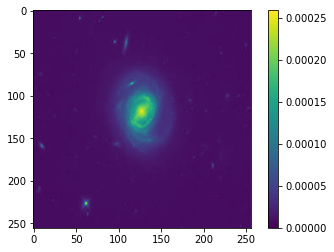

In [18]:
from PIL import Image
img = np.asarray(Image.open('150.jpg'))
img = img/np.sum(img)
print(np.sum(img))
plt.imshow(img)
plt.colorbar()
img = torch.tensor(img)
I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img

In [19]:
from pyvisgen.simulation.scan import get_valid_baselines
import astropy.units as un
from astropy.time import Time
visibilities = Visibilities([], [], [], [], [], [], [], [], [], [], [], [])
vis_num = np.zeros(1)
memory = np.array([])
#i in total number of scans
for i in tqdm(range(72)):
    t = time[i*31:(i+1)*31]
    baselines = scan.get_baselines(src_crd, t, array_layout)
    
    valid = baselines.valid.reshape(-1, 28)
    mask = np.array(valid[:-1]).astype(bool) & np.array(valid[1:]).astype(bool)
    u = baselines.u.reshape(-1, 28)
    v = baselines.v.reshape(-1, 28)
    w = baselines.w.reshape(-1, 28)
    base_valid = np.arange(len(baselines.u)).reshape(-1, 28)[:-1][mask]
    u_valid = u[:-1][mask]
    v_valid = v[:-1][mask]
    w_valid = w[:-1][mask]
    date = np.repeat((t[:-1]+rc['corr_int_time']*un.second/2).jd.reshape(-1, 1), 28, axis=1)[mask] 
    _date = np.zeros(len(u_valid))    
    
    
    X1 = scan.uncorrupted(lm, baselines, wave1, time, src_crd, array_layout, I)
    if X1.shape[0] == 1:
        import os, psutil
        memory = np.append(memory,psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
        continue
    X2 = scan.uncorrupted(lm, baselines, wave1, time, src_crd, array_layout, I)
    
    vis_num = np.arange(X1.shape[2]//2) + 1 + vis_num.max()
    

    int_values = scan.integrate(X1, X2)
    int_values = int_values.reshape(-1,4)
    
    vis = Visibilities(
        int_values[:, 0],
        int_values[:, 1],
        int_values[:, 2],
        int_values[:, 3],
        vis_num,
        np.repeat(i+1, len(vis_num)),
        np.array([baselines[i].baselineNum() for i in base_valid]),
        u_valid,
        v_valid,
        w_valid,
        date,
        _date,      
    )
    
    visibilities.add(vis)
    import os, psutil
    memory = np.append(memory,psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

100%|██████████| 72/72 [01:50<00:00,  1.54s/it]


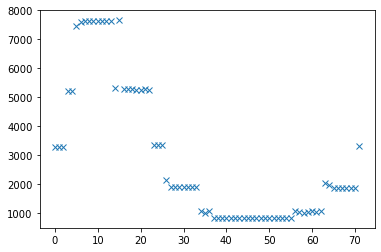

In [24]:
plt.plot(np.arange(0,72), memory, 'x')
plt.show()

In [25]:
import pyvisgen.simulation.utils as ut
import pyvisgen.fits.writer as writer

In [26]:
conf = ut.read_config("../config/default.toml")

In [27]:
hdu_list = writer.create_hdu_list(visibilities, conf)

/scratch/sfroese/envs/radionets/lib/python3.8/site-packages/astropy/io/fits/fitsrec.py:699: UserWarning: Field 2 has a repeat count of 0 in its format code, indicating an empty field.
  warnings.warn(


In [29]:
hdu_list.writeto("test150_default.fits", overwrite=True)

In [30]:
hdu_list[0].data

GroupData([(-0.00239224, 0.00238191, -0.00179945, 1286., 0.5000579, 0., 10., [[[[[[ 1.3189766 , -0.09924979,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ]]]]]]),
           (-0.01390796, 0.02873754,  0.00020443,  264., 0.5000579, 0., 10., [[[[[[-0.01013703, -0.05512502,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ]]]]]]),
           (-0.02030805, 0.02214667,  0.00895961,  262., 0.5000579, 0., 10., [[[[[[ 0.03888816, -0.06817113,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ]]]]]]),
           ...,
           (-0.01750051, 0.01964802,  0.01162184,  261., 1.4895254, 0., 10., [[[[[[ 0.04782799, -0.07510284,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.        ,  1.        ], [ 0.        ,  0.      